# Packages

In [1]:
#dependencies and setup
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import plotly.express as px
from openpyxl import Workbook
import numpy as np
import requests
import json
import re
from pprint import pprint
import time
# SQLite dependencies
import sqlite3
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float
from pandas_profiling import ProfileReport

# DB connection

In [2]:
#  SQLite DB creation and establishing connection
database_path = "NJ_County_DB.sqlite"
engine = create_engine(f"sqlite:///{database_path}", echo=True)
sqlite_connection = engine.connect()

# All tables

In [3]:
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""
tbls= pd.read_sql(sql_query,sqlite_connection)
tbls

2023-03-22 17:09:14,959 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT name FROM sqlite_master  
  WHERE type='table';")
2023-03-22 17:09:14,962 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 17:09:14,965 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT name FROM sqlite_master  
  WHERE type='table';")
2023-03-22 17:09:14,966 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 17:09:14,968 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master  
  WHERE type='table';
2023-03-22 17:09:14,970 INFO sqlalchemy.engine.Engine [raw sql] ()


name
0                    nj_property_tax
1                  nj_mortgage_rates
2                      nj_population
3        nj_zillow_house_value_index
4                     nj_food_desert
5           nj_poverty_median_income
6                    nj_crime_detail
7              nj_school_performance
8      nj_zillow_observed_rent_index
9                             nj_adi
10  nj_counties_dist_to_major_cities

In [4]:
row_count=[]
max_year=[]
for i in tbls['name'].tolist():
    try:
        sql_query = f"""SELECT count(*) as count, MAX(year) as max_year FROM {i};"""
        df = pd.read_sql(sql_query,sqlite_connection)
        row_count.append(df['count'].values[0])
        max_year.append(df['max_year'].values[0])
    except:
        sql_query = f"""SELECT count(*) as count FROM {i};"""
        df = pd.read_sql(sql_query,sqlite_connection)
        row_count.append(df['count'].values[0])
        max_year.append('NaN')
tbls['row_count'] = row_count
tbls['max_year'] = max_year
tbls

2023-03-22 17:09:15,001 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT count(*) as count, MAX(year) as max_year FROM nj_property_tax;")
2023-03-22 17:09:15,002 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 17:09:15,004 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT count(*) as count, MAX(year) as max_year FROM nj_property_tax;")
2023-03-22 17:09:15,005 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 17:09:15,006 INFO sqlalchemy.engine.Engine SELECT count(*) as count, MAX(year) as max_year FROM nj_property_tax;
2023-03-22 17:09:15,007 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 17:09:15,011 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT count(*) as count, MAX(year) as max_year FROM nj_mortgage_rates;")
2023-03-22 17:09:15,013 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 17:09:15,015 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT count(*) as count, MAX(year) as max_year FROM nj_mortgage_rates;")
2023

2023-03-22 17:09:15,205 INFO sqlalchemy.engine.Engine ROLLBACK
2023-03-22 17:09:15,206 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT count(*) as count FROM nj_counties_dist_to_major_cities;")
2023-03-22 17:09:15,207 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 17:09:15,209 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT count(*) as count FROM nj_counties_dist_to_major_cities;")
2023-03-22 17:09:15,209 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 17:09:15,211 INFO sqlalchemy.engine.Engine SELECT count(*) as count FROM nj_counties_dist_to_major_cities;
2023-03-22 17:09:15,212 INFO sqlalchemy.engine.Engine [raw sql] ()


name  row_count max_year
0                    nj_property_tax       3384     2022
1                  nj_mortgage_rates         32     2022
2                      nj_population        252     2021
3        nj_zillow_house_value_index       2520     2023
4                     nj_food_desert       2002      NaN
5           nj_poverty_median_income        105     2021
6                    nj_crime_detail       9646     2020
7              nj_school_performance       8888     2020
8      nj_zillow_observed_rent_index        180     2023
9                             nj_adi       6437      NaN
10  nj_counties_dist_to_major_cities         21      NaN

# Crime

In [7]:
sql_query = """SELECT * FROM nj_crime_detail;"""
crime_df = pd.read_sql(sql_query,sqlite_connection)
crime_df.info()

2023-03-22 19:53:47,701 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM nj_crime_detail;")
2023-03-22 19:53:47,726 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 19:53:47,749 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM nj_crime_detail;")
2023-03-22 19:53:47,751 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 19:53:47,756 INFO sqlalchemy.engine.Engine SELECT * FROM nj_crime_detail;
2023-03-22 19:53:47,758 INFO sqlalchemy.engine.Engine [raw sql] ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9646 entries, 0 to 9645
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   county_name  9646 non-null   object 
 1   year         9646 non-null   int64  
 2   agency       9646 non-null   object 
 3   report_type  9646 non-null   object 
 4   population   9521 non-null   float64
 5   murder       9646 non-null   float64
 6   rape         9646 non-null   float64
 7   ro

In [5]:
df = crime_df[crime_df['report_type']=='Rate Per 100,000'].groupby(['county_name', 'year'],\
                                                                             as_index=False).mean()
# crime by county trend
fig = px.line(df, x="year", y = 'total', title='Crime by County',\
              color='county_name', markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [2017,2018,2019,2020],
        ticktext = [2017,2018,2019,2020]
    ),
        yaxis_title="Crime Per 100k population"
)
fig.show()

In [6]:
# crime by type trend
crime_type=df.groupby('year',as_index=False).mean()
fig = px.line(crime_type, x="year", y = crime_type.columns[2:-1], title='Crime by types', markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [2017,2018,2019,2020],
        ticktext = [2017,2018,2019,2020]
    ),
        yaxis_title="Crime Per 100k population"
)
fig.show()

# Poverty and Median Income

In [48]:
sql_query = """SELECT * FROM nj_poverty_median_income;"""
pov_mhi_df = pd.read_sql(sql_query,sqlite_connection)
pov_mhi_df.info()

2023-03-21 16:03:45,892 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM nj_poverty_median_income;")
2023-03-21 16:03:45,895 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 16:03:45,903 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM nj_poverty_median_income;")
2023-03-21 16:03:45,905 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 16:03:45,907 INFO sqlalchemy.engine.Engine SELECT * FROM nj_poverty_median_income;
2023-03-21 16:03:45,909 INFO sqlalchemy.engine.Engine [raw sql] ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   county_name       105 non-null    object 
 1   median_hh_income  105 non-null    int64  
 2   poverty_count     105 non-null    int64  
 3   poverty_rate      105 non-null    float64
 4   st_abb            105 non-null    object 
 5   year              105 non-n

In [8]:
# trend
fig = px.line(pov_mhi_df, x="year", y="poverty_rate", title='Poverty', color='county_name', markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [2017,2018,2019,2020,2021],
        ticktext = [2017,2018,2019,2020,2021]
    )
)
fig.show()

In [9]:
# trend
fig = px.line(pov_mhi_df, x="year", y="median_hh_income", title='Median Income', color='county_name', markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [2017,2018,2019,2020,2021],
        ticktext = [2017,2018,2019,2020,2021]
    )
)
fig.show()

# School Performance

In [5]:
sql_query = """SELECT * FROM nj_school_performance;"""
school_df = pd.read_sql(sql_query,sqlite_connection)
school_df.info()

2023-03-22 17:09:17,381 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM nj_school_performance;")
2023-03-22 17:09:17,386 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 17:09:17,388 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM nj_school_performance;")
2023-03-22 17:09:17,389 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 17:09:17,390 INFO sqlalchemy.engine.Engine SELECT * FROM nj_school_performance;
2023-03-22 17:09:17,392 INFO sqlalchemy.engine.Engine [raw sql] ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8888 entries, 0 to 8887
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rank            8888 non-null   int64  
 1   school          8888 non-null   object 
 2   grades          8888 non-null   object 
 3   district        8888 non-null   object 
 4   students        8888 non-null   int64  
 5   free_lunch_rec  8863 non-null   float64
 6   to

In [6]:
school_df.head()

rank                                    school    grades  \
0     1            Deane-Porter Elementary School  PK, KG-3   
1     2                                 School 28  PK, KG-8   
2     3  Thomas Edison EnergySmart Charter School      K-12   
3     4             Terence C. Reilly School No 7       2-8   
4     5                          Deerfield School       K-4   

                                   district  students  free_lunch_rec  \
0            Rumson Borough School District       384            0.00   
1           Paterson Public School District       488           82.60   
2  Thomas Edison EnergySmart Charter School       421            9.70   
3                  Elizabeth Public Schools      1055           73.50   
4         Millburn Township School District       563            0.50   

   total_exp  score  year school_type                          type  \
0  11,020.00  98.30  2017  Elementary                        Public   
1   9,579.00  97.80  2017  Elementary                        Public   
2   7,387.00  96.50  2017  Elementary  Public, Charter, Alternative   
3   7,777.00  96.20  2017  Elementary                        Public   
4  13,641.00  96.10  2017  Elementary                        Public   

                      address         city    zip county_name  
0          50 Blackpoint Road       Rumson  07760    MONMOUTH  
1  200 Presidential Boulevard     Paterson  07522     PASSAIC  
2           150 Pierce Street     Somerset  08873    SOMERSET  
3            436 First Avenue    Elizabeth  07206       UNION  
4                26 Troy Lane  Short Hills  07078       ESSEX

In [63]:
# trend - County
df = school_df.groupby(['year', 'county_name']).agg(MeanScore=('score', 'mean')).reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
# trend
fig = px.line(df, x="year", y="MeanScore", title='School Scores by County', color='county_name', markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [2017,2018,2019,2020],
        ticktext = [2017,2018,2019,2020]
    )
)
fig.show()

In [64]:
# trend - Shcool types/ phases
df = school_df.groupby(['year', 'school_type']).agg(MeanScore=('score', 'mean')).reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
# trend
fig = px.line(df, x="year", y="MeanScore", title='School Scores by School Types', color='school_type', markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [2017,2018,2019,2020],
        ticktext = [2017,2018,2019,2020]
    )
)
fig.show()

In [65]:
# trend - type
df = school_df.groupby(['year', 'type']).agg(MeanScore=('score', 'mean')).reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
# trend
fig = px.line(df, x="year", y="MeanScore", title='School Scores by Type', color='type', markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [2017,2018,2019,2020],
        ticktext = [2017,2018,2019,2020]
    )
)
fig.show()

# Zillow House Price Index

In [14]:
sql_query = """SELECT * FROM nj_zillow_house_value_index;"""
zhvi_df = pd.read_sql(sql_query,sqlite_connection)
zhvi_df.info()

2023-03-21 15:46:55,860 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM nj_zillow_house_value_index;")
2023-03-21 15:46:55,861 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 15:46:55,863 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM nj_zillow_house_value_index;")
2023-03-21 15:46:55,864 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 15:46:55,866 INFO sqlalchemy.engine.Engine SELECT * FROM nj_zillow_house_value_index;
2023-03-21 15:46:55,867 INFO sqlalchemy.engine.Engine [raw sql] ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520 entries, 0 to 2519
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county_name        2520 non-null   object 
 1   year               2520 non-null   int64  
 2   num_of_bedrooms    2520 non-null   int64  
 3   house_value_index  2500 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 78.9+ KB

In [15]:
# trend
df = zhvi_df.groupby(['year','num_of_bedrooms'],as_index=False).agg({'house_value_index':'mean'})
fig = px.line(df, x="year", y = 'house_value_index', color='num_of_bedrooms',\
              title='Price by bedrooms in NJ', markers=True)
fig.show()

In [16]:
# trend
df = zhvi_df.groupby(['year','county_name'],as_index=False).agg({'house_value_index':'mean'})
fig = px.line(df, x="year", y = 'house_value_index', color='county_name',\
              title='Price by county in NJ', markers=True)
fig.show()

# Zillow Observed Rent Index

In [75]:
sql_query = """SELECT * FROM nj_zillow_observed_rent_index;"""
zori_df = pd.read_sql(sql_query,sqlite_connection)
zori_df.info()

2023-03-21 16:32:02,740 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM nj_zillow_observed_rent_index;")
2023-03-21 16:32:02,746 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 16:32:02,763 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM nj_zillow_observed_rent_index;")
2023-03-21 16:32:02,765 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 16:32:02,766 INFO sqlalchemy.engine.Engine SELECT * FROM nj_zillow_observed_rent_index;
2023-03-21 16:32:02,767 INFO sqlalchemy.engine.Engine [raw sql] ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   county_name          180 non-null    object 
 1   year                 180 non-null    int64  
 2   observed_rent_index  157 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.3+ KB


In [76]:
# trend
fig = px.line(zori_df, x="year", y = 'observed_rent_index', color='county_name',\
              title='Rent Price by county in NJ', markers=True)
fig.show()

# Property Tax

In [13]:
sql_query = """SELECT * FROM nj_property_tax;"""
tax_df = pd.read_sql(sql_query,sqlite_connection)
tax_df.info()

2023-03-22 20:11:55,899 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM nj_property_tax;")
2023-03-22 20:11:55,901 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 20:11:55,903 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM nj_property_tax;")
2023-03-22 20:11:55,904 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-22 20:11:55,906 INFO sqlalchemy.engine.Engine SELECT * FROM nj_property_tax;
2023-03-22 20:11:55,909 INFO sqlalchemy.engine.Engine [raw sql] ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3384 entries, 0 to 3383
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   county_code    3384 non-null   object 
 1   county_name    3384 non-null   object 
 2   district_code  3384 non-null   object 
 3   district_name  3384 non-null   object 
 4   year           3384 non-null   int64  
 5   tax_rate       3384 non-null   float64
dtypes: float64(1), int64(1), obje

In [4]:
tax_df.head()

county_code county_name district_code       district_name  year  tax_rate
0         001    ATLANTIC            01        ABSECON CITY  2017      3.27
1         001    ATLANTIC            01  ATLANTIC CITY CITY  2017      3.42
2         001    ATLANTIC            01     BRIGANTINE CITY  2017      1.76
3         001    ATLANTIC            01          BUENA BORO  2017      3.03
4         001    ATLANTIC            01     BUENA VISTA TWP  2017      2.46

In [20]:
# trend
df = tax_df.groupby(['year', 'county_name']).agg(tax_rate=('tax_rate','mean')).reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
fig = px.line(df, x="year", y="tax_rate", title='Property Tax Rate', color='county_name', markers=True)
fig.show()

In [16]:
tax_df[tax_df['year']==2022].groupby(['county_name']).agg({'tax_rate':['min','mean','max']})

tax_rate           
                 min mean   max
county_name                    
ATLANTIC        1.01 3.01  5.45
BERGEN          0.74 2.55  4.23
BURLINGTON      1.28 3.08  4.87
CAMDEN          1.74 4.29  7.83
CAPE MAY        0.57 1.43  2.83
CUMBERLAND      2.37 3.30  5.03
ESSEX           1.94 3.14  5.96
GLOUCESTER      2.09 3.66  4.89
HUDSON          1.58 4.01 10.54
HUNTERDON       2.09 2.94  4.25
MERCER          2.43 3.36  5.46
MIDDLESEX       1.78 5.07 11.46
MONMOUTH        0.52 1.74  3.03
MORRIS          1.13 2.56  3.27
OCEAN           0.70 1.99  3.25
PASSAIC         2.44 4.10  5.71
SALEM           1.62 3.73  7.52
SOMERSET        1.33 2.37  4.08
SUSSEX          0.72 3.27  4.56
UNION           2.00 7.94 30.58
WARREN          2.31 3.52  5.87

# Mortgage Rates

In [21]:
sql_query = """SELECT * FROM nj_mortgage_rates;"""
apr_df = pd.read_sql(sql_query,sqlite_connection)
apr_df.info()

2023-03-21 15:46:56,535 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM nj_mortgage_rates;")
2023-03-21 15:46:56,538 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 15:46:56,538 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM nj_mortgage_rates;")
2023-03-21 15:46:56,539 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 15:46:56,541 INFO sqlalchemy.engine.Engine SELECT * FROM nj_mortgage_rates;
2023-03-21 15:46:56,542 INFO sqlalchemy.engine.Engine [raw sql] ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       32 non-null     int64  
 1   apr_30     32 non-null     float64
 2   points_30  32 non-null     float64
 3   apr_15     32 non-null     float64
 4   points_15  32 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.4 KB


In [22]:
# trend
fig = px.line(apr_df, x="year", y = apr_df.columns[1:], title='Mortgage APR', markers=True)
fig.show()

# Population

In [23]:
sql_query = """SELECT * FROM nj_population;"""
pop_df = pd.read_sql(sql_query,sqlite_connection)
pop_df.info()

2023-03-21 15:46:56,682 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM nj_population;")
2023-03-21 15:46:56,684 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 15:46:56,686 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM nj_population;")
2023-03-21 15:46:56,687 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 15:46:56,688 INFO sqlalchemy.engine.Engine SELECT * FROM nj_population;
2023-03-21 15:46:56,689 INFO sqlalchemy.engine.Engine [raw sql] ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   county_name  252 non-null    object
 1   est_pop      252 non-null    int64 
 2   year         252 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 6.0+ KB


In [24]:
# trend
fig = px.line(pop_df, x="year", y = 'est_pop', color='county_name',\
              title='Population (Est) in NJ', markers=True)
fig.show()

# Food Desert

In [25]:
sql_query = """SELECT * FROM nj_food_desert;"""
food_df = pd.read_sql(sql_query,sqlite_connection)
food_df.info(verbose=True, null_counts=True)

2023-03-21 15:46:56,866 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM nj_food_desert;")
2023-03-21 15:46:56,867 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 15:46:56,869 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM nj_food_desert;")
2023-03-21 15:46:56,872 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 15:46:56,874 INFO sqlalchemy.engine.Engine SELECT * FROM nj_food_desert;
2023-03-21 15:46:56,875 INFO sqlalchemy.engine.Engine [raw sql] ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002 entries, 0 to 2001
Data columns (total 148 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    censustract           2002 non-null   int64  
 1    state                 2002 non-null   object 
 2    county                2002 non-null   object 
 3    urban                 2002 non-null   int64  
 4    pop2010               2002 non-null   int64  
 5    ohu2010          

<ipython-input-25-02ebe01409f7>:3: FutureWarning:

null_counts is deprecated. Use show_counts instead



In [26]:
# trend
df = food_df.groupby(['county_name'],as_index=False).agg({'la1and10':'sum','lahalfand10':'sum',
                                                             'la1and20':'sum'})
fig = px.bar(df, x="county_name", y = df.columns[1:],\
              title='Food desert tracts by county in NJ', barmode='group')
fig.show()

# Area Deprivation Index

In [103]:
sql_query = """SELECT * FROM nj_adi;"""
adi_df = pd.read_sql(sql_query,sqlite_connection)
adi_df.info()

2023-03-21 17:46:30,843 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM nj_adi;")
2023-03-21 17:46:30,845 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 17:46:30,849 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM nj_adi;")
2023-03-21 17:46:30,850 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 17:46:30,852 INFO sqlalchemy.engine.Engine SELECT * FROM nj_adi;
2023-03-21 17:46:30,853 INFO sqlalchemy.engine.Engine [raw sql] ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6437 entries, 0 to 6436
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GISJOIN       6437 non-null   object 
 1   ADI_NATRANK   6437 non-null   float64
 2   ADI_STATERNK  6437 non-null   float64
 3   FIPS          6437 non-null   object 
 4   county_code   6437 non-null   object 
 5   county_name   6437 non-null   object 
dtypes: float64(2), object(4)
memory usage: 301.9+ KB


In [97]:
# trend
df = adi_df.groupby(['county_name'],as_index=False).agg({'ADI_NATRANK':'mean',
                                                             'ADI_STATERNK':'mean'})
fig = px.bar(df, x="county_name", y = df.columns[1:],\
              title='ADI Ranking by county in NJ', barmode='group')
fig.show()

# Distance from Major Cities

In [104]:
sql_query = """SELECT * FROM nj_counties_dist_to_major_cities;"""
distance_df = pd.read_sql(sql_query,sqlite_connection)
distance_df.info()

2023-03-21 17:46:36,933 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM nj_counties_dist_to_major_cities;")
2023-03-21 17:46:36,939 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 17:46:36,944 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM nj_counties_dist_to_major_cities;")
2023-03-21 17:46:36,945 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-03-21 17:46:36,948 INFO sqlalchemy.engine.Engine SELECT * FROM nj_counties_dist_to_major_cities;
2023-03-21 17:46:36,949 INFO sqlalchemy.engine.Engine [raw sql] ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_name           21 non-null     object 
 1   county_code           21 non-null     object 
 2   dist_to_manhattan     21 non-null     float64
 3   dist_to_queens        21 non-null     float64
 4   dist_to_brooklyn      21 no

In [105]:
# trend
for i in distance_df.select_dtypes('float').columns:
        fig=px.bar(distance_df, x="county_name", y = i,\
              title=f'''Distance from {i.replace('dist_to_','').title()} by county in NJ''',\
                   barmode='group')
        fig.show()

In [31]:
# close connection
sqlite_connection.close()

# Combining all domains

In [33]:
for name in vars().keys():
    if '_df' in name:
        print(name)

crime_df
pov_mhi_df
school_df
zhvi_df
zori_df
tax_df
apr_df
pop_df
food_df
adi_df
distance_df


In [98]:
# Aggregation at the county level
crime_df_agg = crime_df[crime_df['report_type']=='Rate Per 100,000'].drop('population',\
                                                                          axis=1).groupby(['county_name', \
                                                                                           'year'],\
                                                                             as_index=False).mean()
school_df_agg = school_df.groupby(['year', 'county_name']).agg(MeanScore=('score', 'mean')).reset_index()
tax_df_agg = tax_df.groupby(['year', 'county_name']).agg(tax_rate=('tax_rate', 'mean')).reset_index()
food_df_agg = food_df.groupby(['county_name'],as_index=False).agg({'la1and10':'sum','lahalfand10':'sum',
                                                             'la1and20':'sum'})
adi_df_agg = adi_df.groupby(['county_name'],as_index=False).agg({'ADI_NATRANK':'mean',
                                                             'ADI_STATERNK':'mean'})

# Just 2020

In [107]:
#  joinig all 2020 rows
all_2020_df=pd.merge(crime_df_agg[crime_df_agg['year']==2020], \
                  pov_mhi_df[pov_mhi_df['year']==2020].drop(['st_abb', 'state_code', 'county_code'],axis=1),\
                  how='inner', on = ['county_name', 'year']).drop('year',axis=1)
all_2020_df=pd.merge(all_2020_df, school_df_agg[school_df_agg['year']==2020].drop('year',axis=1), how='inner',\
                  on = 'county_name')
all_2020_df=pd.merge(all_2020_df, zhvi_df[zhvi_df['year']==2020].drop('year',\
                                            axis=1).groupby('county_name',\
                                            as_index=False).agg({'house_value_index':'mean'}),\
                how='inner',   on = 'county_name')
all_2020_df=pd.merge(all_2020_df, zori_df[zori_df['year']==2020].drop('year',axis=1),\
                  how='inner', on='county_name')
all_2020_df=pd.merge(all_2020_df,tax_df_agg[tax_df_agg['year']==2020].drop('year',axis=1),\
               how='inner', on='county_name')
all_2020_df=pd.merge(all_2020_df,pop_df[pop_df['year']==2020].drop('year',axis=1),\
               how='inner', on='county_name')
all_2020_df=pd.merge(all_2020_df,food_df_agg, how='inner', on='county_name')
all_2020_df=pd.merge(all_2020_df,adi_df_agg, how='inner', on='county_name')
all_2020_df=pd.merge(all_2020_df,distance_df, how='inner', on='county_name')
all_2020_df

county_name  murder  rape  robbery  assault  burglary  larceny  auto_theft  \
0     ATLANTIC    3.00 12.68    41.55    95.54    274.96 1,287.86       81.83   
1       BERGEN    0.41  4.33    10.48    29.65     70.74 2,243.08       94.14   
2   BURLINGTON    2.56 17.19    18.47    98.75    117.88   720.39       56.77   
3       CAMDEN    1.71  8.70    50.15   142.79    230.76 1,551.97       96.20   
4   CUMBERLAND    3.85 18.35    87.75   231.95    286.87 1,164.85       78.72   
5        ESSEX    2.11  8.33    31.91    53.10     96.19   564.39      141.56   
6   GLOUCESTER    2.30  2.87    21.88    68.83    152.47   825.12       57.14   
7       HUDSON    0.56  9.37    36.61    81.19     83.30   696.22       71.81   
8    HUNTERDON    1.24  0.78     0.20    11.95     58.86   294.44       22.16   
9       MERCER    2.20  7.93    19.97    56.78     61.80   329.56       35.63   
10   MIDDLESEX    1.02  6.07    14.75    62.93     80.65   570.99       49.09   
11    MONMOUTH    0.12 11.56    17.81    67.53    133.32   993.27      109.26   
12      MORRIS    0.44  4.73     6.26    29.35     80.26   484.50       57.23   
13       OCEAN    0.44  8.53    19.43    84.27    129.56 1,010.39       97.07   
14     PASSAIC    1.20  5.97    31.24    80.28     81.72   599.26       67.47   
15       SALEM   30.65 34.56    80.32   180.04    315.64   799.85      111.89   
16    SOMERSET    0.30  4.56     9.13    12.22     84.49   630.63       62.93   
17      SUSSEX    1.41  8.24     0.91    28.61     47.80   262.64       17.12   
18       UNION    1.79  9.50    27.22    56.83     81.37   604.69       99.97   
19      WARREN    0.00  7.19     7.71    32.80    160.09   894.20       32.66   

      total  median_hh_income  ...  ADI_STATERNK  county_code  \
0  1,797.43             61377  ...          8.03          001   
1  2,452.84            107114  ...          3.42          003   
2  1,032.01             92471  ...          6.66          005   
3  2,082.29             71718  ...          8.26          007   
4  1,872.30             60352  ...          9.34          011   
5    897.59             65528  ...          5.76          013   
6  1,130.61             87220  ...          7.39          015   
7    979.08             77323  ...          4.76          017   
8    389.63            113611  ...          4.00          019   
9    513.86             87581  ...          6.46          021   
10   785.51             95610  ...          5.29          023   
11 1,332.86            104219  ...          3.97          025   
12   662.77            114103  ...          3.43          027   
13 1,349.69             78181  ...          6.08          029   
14   867.17             64422  ...          6.16          031   
15 1,552.90             65563  ...          8.71          033   
16   804.28            115573  ...          4.07          035   
17   366.71             92739  ...          6.60          037   
18   881.40             83189  ...          5.48          039   
19 1,134.63             80412  ...          7.27          041   

    dist_to_manhattan  dist_to_queens  dist_to_brooklyn  dist_to_bronx  \
0               51.68           62.88             52.48          61.56   
1                6.66           17.59              7.74          14.58   
2               48.51           60.21             49.41          58.52   
3               68.29           80.19             69.24          78.31   
4               80.51           92.24             81.43          90.53   
5               16.81           29.00             17.93          26.46   
6               80.88           92.83             81.85          90.90   
7                4.75           16.94              5.88          14.56   
8               62.91           75.10             63.97          72.72   
9               48.91           60.99             49.92          58.89   
10              28.57           40.64             29.57          38.57   
11              17.28           28.53          

In [124]:
corr = all_2020_df.corr()
fig = px.imshow(corr, aspect="auto",height=1000, title ='Correlation heatmap for 2020 data by Plotly')
fig.show()

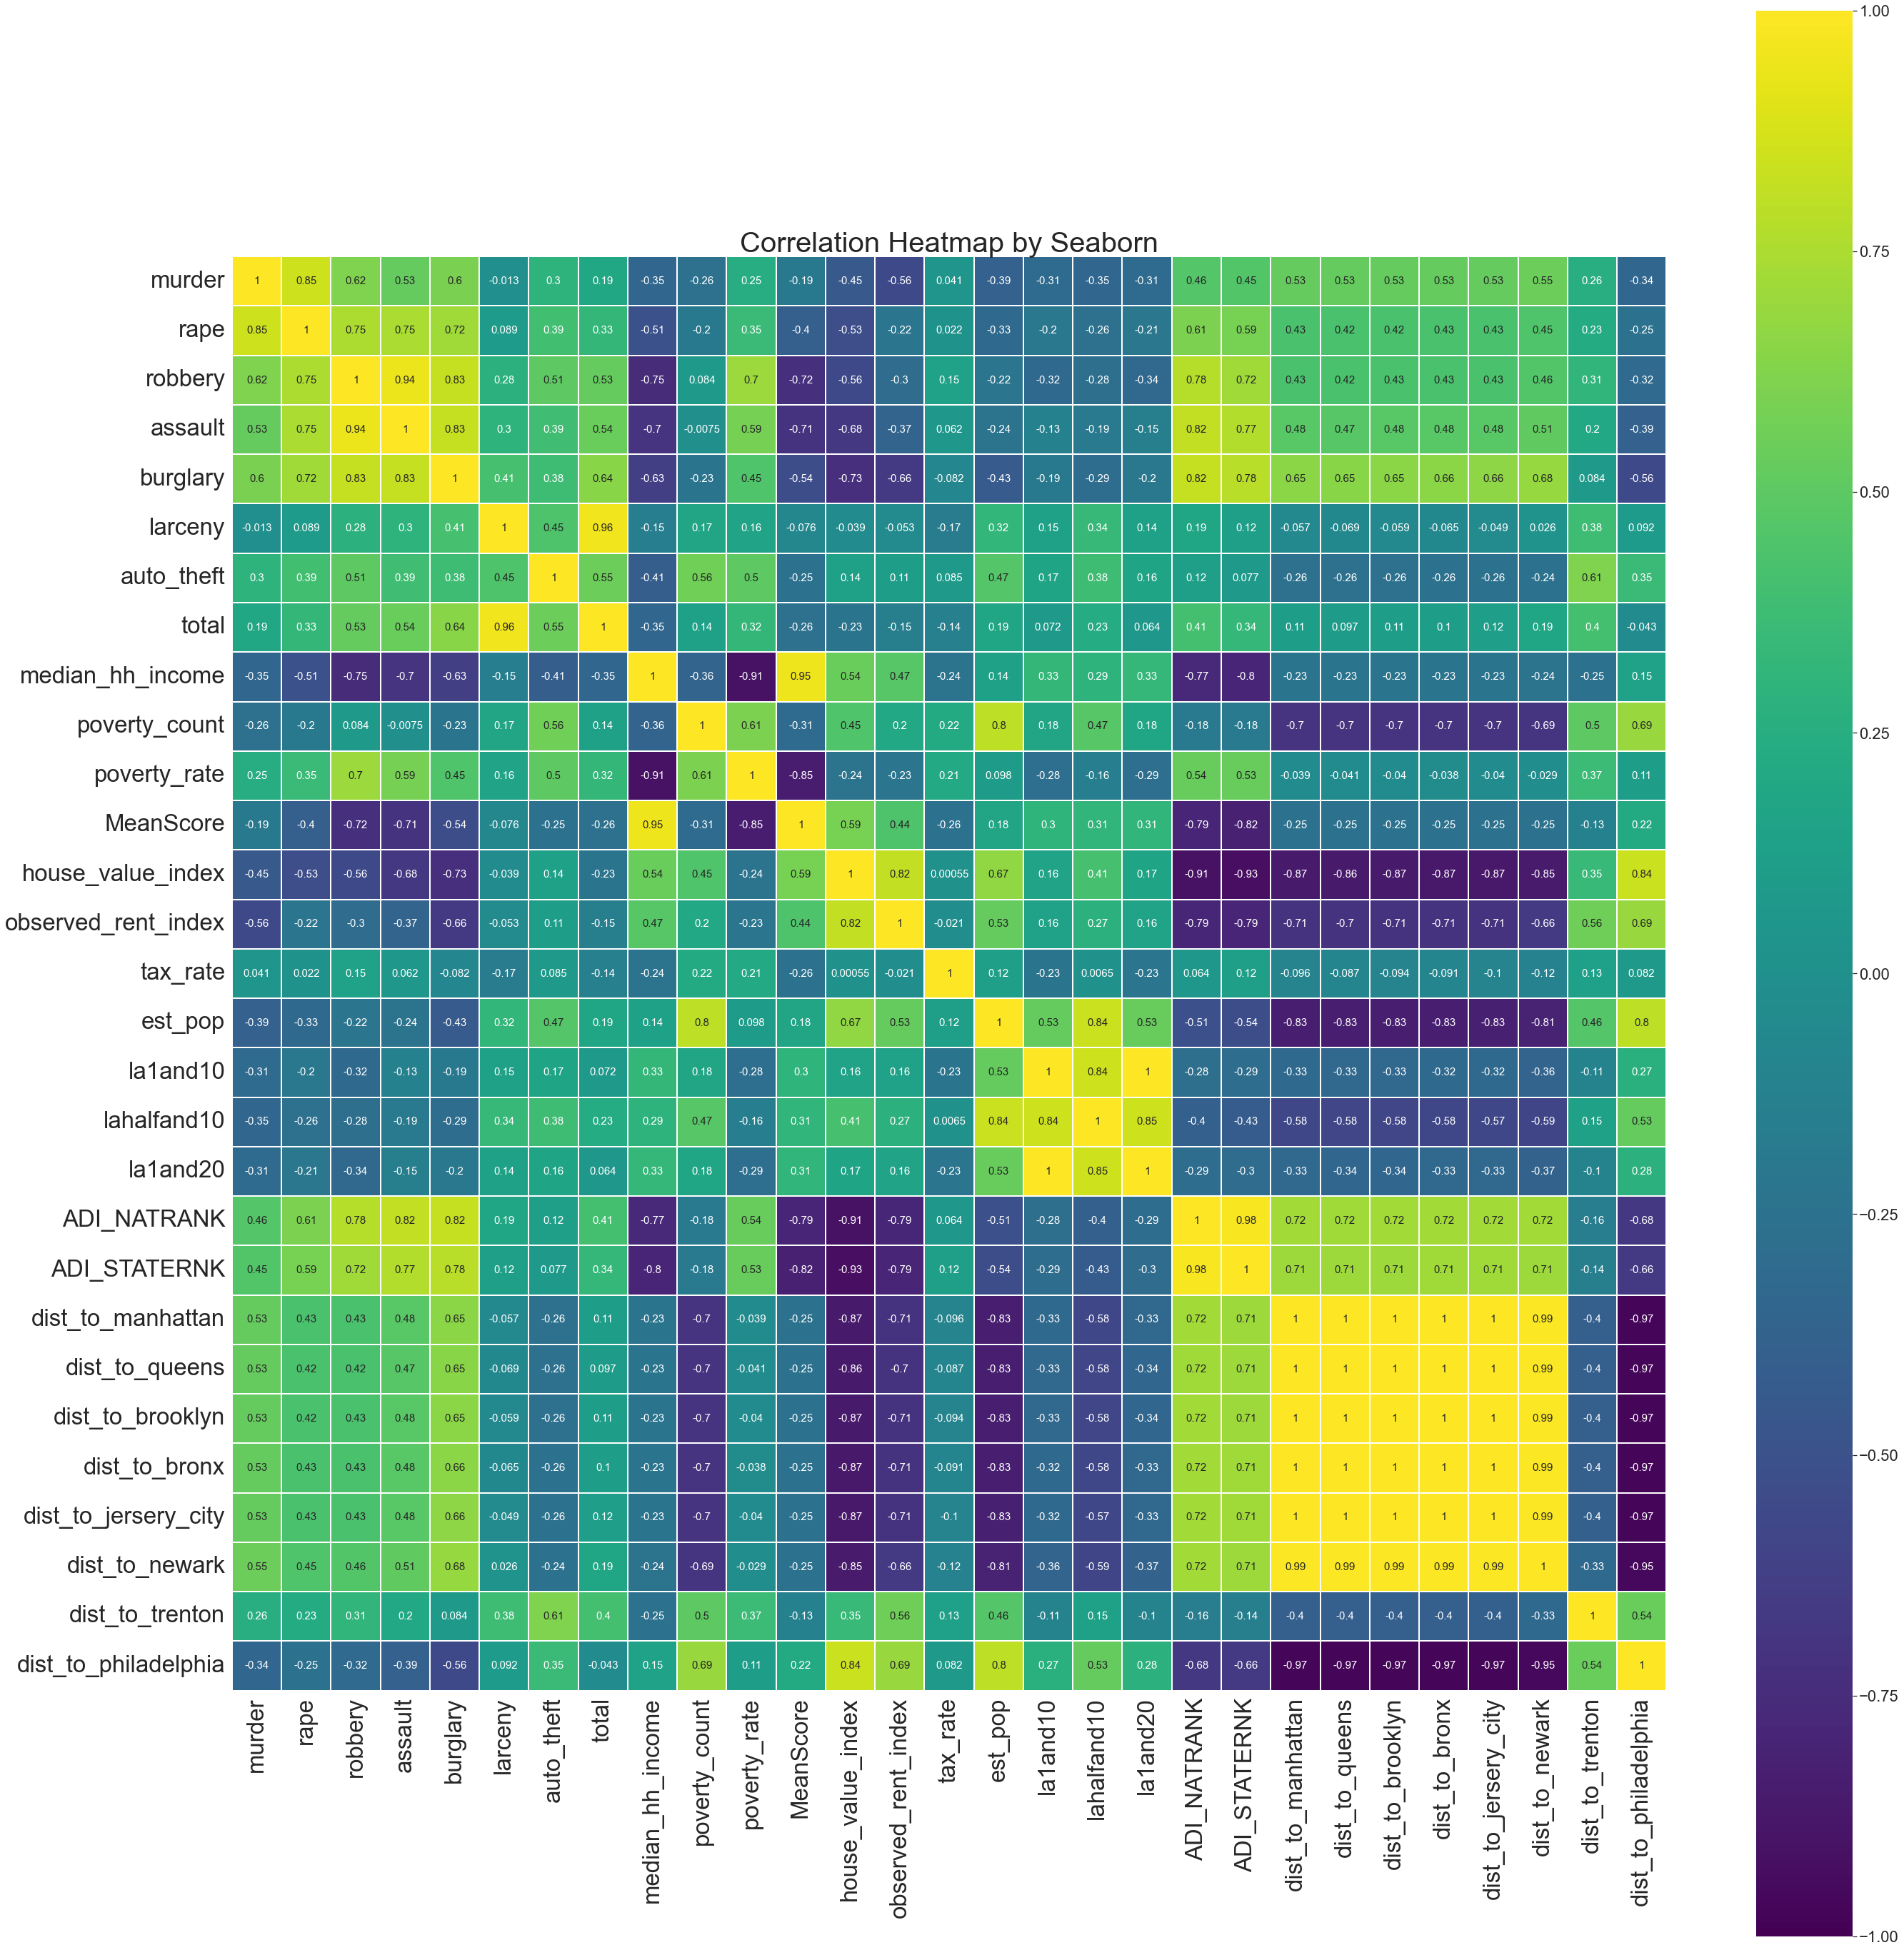

In [144]:
# correlation heatmap
corr = all_2020_df.corr()
plt.figure(figsize=(40, 40))
plt.title('Correlation Heatmap by Seaborn', fontsize =40)
sns.set(font_scale=2)
sns.heatmap(corr
#             [(corr >= 0.6) | (corr <= -0.6)]
            , 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 15}, square=True)
plt.tight_layout()
plt.show()